# Uses For PCA Other Than Dimensionality Reduction Part 2
## Imputation, and Noise Reduction

Principal Component Analysis (PCA) is frequently applied in machine learning as a sort of black box dimensionality reduction technique. However with a deeper understanding of what PCA is and what it does we can use it for all manner of other tasks e.g.

<!-- TEASER_END -->

* Decorrelating Variables
* Semantic Factor Discovery
* Empirical Noise Modeling
* Missing Data Imputation 
* Example Generation 
* Anomaly Detection
* Patchwise Modeling
* Noise Reduction

In part one of this series of blog posts we talked about decorrelation, semantic factor discovery (by analyzing the principal vectors), and empirical noise modeling. 

<a href="other_uses_for_PCA_part1.html">Part 1 </a>

In this post we will be talking about using PCA to make clever guesses for missing values in our data and/or reconstructing a lower noise version of our inputs. Replacing missing values in our data is often called "imputation".

First we load our data and redefine some helper functions from the last post. 

Changes:
March 1, 2019: Altered the implementation to include an ortho

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import sklearn
import sklearn.datasets
import sklearn.decomposition


In [3]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(10,6),
        "font.size":16,
        "image.cmap":"afmhot",
        "image.interpolation":"nearest",
        "image.aspect":"auto",
    }
)

In [4]:
faces_ds = sklearn.datasets.fetch_olivetti_faces()

faces = faces_ds["data"]
#divide by the global standard deviation
faces /= np.std(faces)

subject_ids = faces_ds["target"]

im_shape = (64, 64)

def as_image(arr):
    return arr.reshape(im_shape)
    
def view_as_image(arr, ax=None, **imshow_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axis("off")
    im = ax.imshow(as_image(arr), **imshow_kwargs)
    return im


## Injecting Missing Values

It would not be a fair test of PCA's ability to handle missing data if we train it on a datset which has no missing values at all. So in order to make things interesting we will first replace 20% of the pixel values in our input data with zeros. Because we are dealing with image data and neighboring pixels tend to share a lot of information it is much harder to deal with lots of missing pixels all in the same area than it is to deal with pixels randomly scattered around the image. To make things even more challenging we will try to mostly cut out image chunks several pixels wide at a time.

In [5]:
np.random.seed(1234)

occlusion_fraction = 0.2

hole_scale = 3
#generate random uncorrelated noise
occlusion_mask = np.random.normal(size=[len(faces)] + list(im_shape))

#Smooth the noise locally to make the noise fluctuations change only on several pixel scale
occlusion_mask = scipy.ndimage.filters.gaussian_filter(occlusion_mask, hole_scale)
occlusion_mask = occlusion_mask > np.percentile(occlusion_mask, 100*occlusion_fraction)
#flatten to match face data shape

occlusion_mask = occlusion_mask.reshape((len(faces), -1))

occluded_faces = faces*occlusion_mask

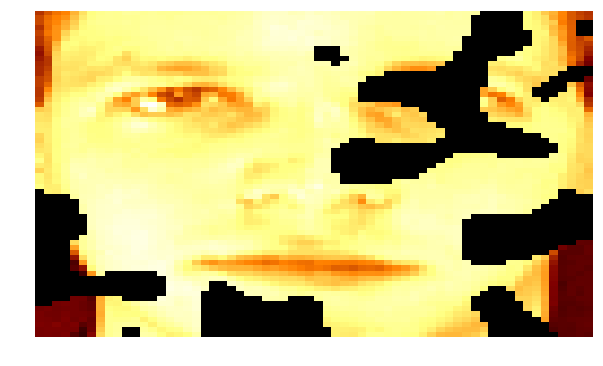

In [6]:
view_as_image(occluded_faces[0])

Although we can still feed this data directly in to the PCA object in sklearn like we did in part 1 the results will be rather less than satisfactory. PCA tends not to deal well with large outliers in our data and each of these occlusions has a much more dramatic effect on the data than the more subtle differences caused by changes in facial structure or orientation. If we don't give the missing points any special treatment the principal components that we will get will tell us more about the distribution of pixels we randomly decided to remove than it will about the structure of faces.

In [7]:
occluded_sklearn_pca = sklearn.decomposition.PCA()
occluded_sklearn_pca.fit(occluded_faces)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

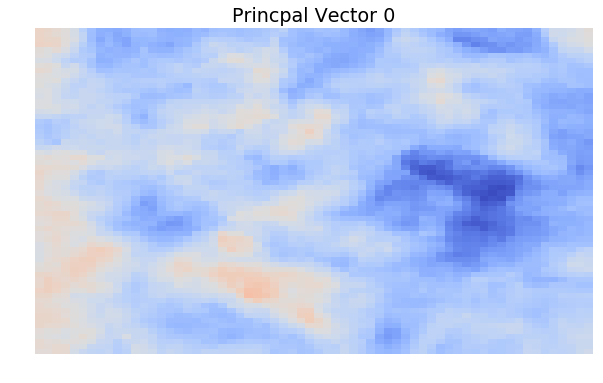

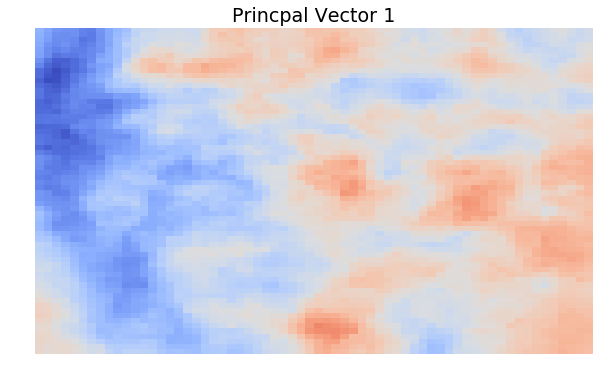

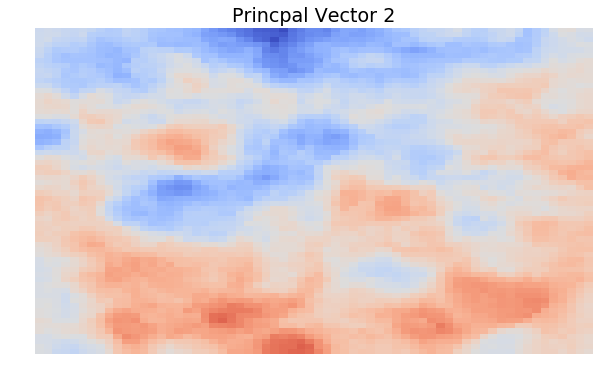

In [8]:
for i in range(3):
    comp = occluded_sklearn_pca.components_[i]
    mag_max = np.max(np.abs(comp))
    view_as_image(comp, vmin=-mag_max, vmax=mag_max, cmap="coolwarm")
    plt.title("Princpal Vector {}".format(i))

These principal vectors leave something to be desired to say the least. However in principle we have done something which is informationally equivalent to removing 50% of our faces leaving us with just 200 instead of 400. We should still be able to get reasonably good results even with 50% of our data missing.
As I mentioned briefly in part 1 of these posts PCA is equivalent to the solution of a least squares problem;

$$
X \approx \hat{X} = W~H
$$

where W is a N by k matrix of weight coefficents (which we called the principal components) and H was a k by m matrix where m is the number of features in our data matrix X. It turns out that SVD (which is how sklearn computes the PCA expansion) gives the solution to the least squares problem where each point is given equal weight. However we can easily reformulate our problem to include a quality weighting for our input data giving weight 0 to the points we have occluded. That is we wish to minimize a metric $\chi^2$ which we define as follows;

$$
\delta_i = X_i - \hat{X}_i = X_i - W_i~H
$$

$$
\chi^2 = \sum_i^N \delta_i^T C_i^{-1} \delta_i
$$

Here we are using the subscript $i$ to indicate the row index in the original dataset so $X_i$ is the i'th observation and $W_i$ is the corresponding row of weights in the W matrix etc. The weights given to each input point are encoded in the matrix $C_i^{-1}$ which is the inverse of the noise covariance matrix of our data. In our particular case there is no correlation between the noise in each pixel and so the covariance matrix is simply a diagonal matrix with zero entries for missing pixels (corresponding to infinite noise) and non-zero entries corresponding to the inverse of the noise variance in each pixel. 

There is a complication to the use of least squares for finding a PCA expansion that we glossed over earlier which is that there is some amount of degeracy between the coefficents of W and H. We can always decrease the entries in W by a factor of 2 and double the magnitude of the vectors in H and end up with the same approximation matrix $\hat{X}$. We can remove this degeracy by requiring H to be orthonormal. There is still some ambiguity since any permutation of the columns of W and the rows of H will also give the same approximation matrix. This is easy to handle since we simply need to reorder the columns of W in order of decreasing total variance as a post processing step.

Solving this optimization problem is far from trivial. We will try and make progress on the large optimization problem by solving a much simpler sub-problem repeatedly. We shall begin with a set of randomly chosen H and W and then propose updates to H and W which slightly improve our model. We will propose updates which affect only one component at a time and iterate through all components. Focusing for a moment on just a single row $X_i$ in our data it should be intuitively clear that we could perfectly reconstruct $X_i$ by choosing to update our principal vector by choosing a new principa vector proportional to that row $H_j \propto X_i$. 
Since we have many rows instead of just one we can pick the optimal $H_j$ simply by taking the weighted average of all of our rows. We want to take into account both the data weights and the fact that each row has a different "amount" of each principal vector in it as indicated by the magnitude of the corresponding W coefficient. Iteratively proposig updates which take the weighted average of the residuals to our data in this way and then enforcing orthonormality by simply orthogonalizing our principal vectors every now and again actually works reasonably well (see the code below). 

In [20]:
def partial_outer_product(
    w, #(nrows, rank)
    h_t, #(ncols, rank)
    row_indexes, 
    col_indexes, 
    output_format="raw",
):
    """
    Evaluates the product wh on a small footprint of matrix locations corresponding to the row/column pairs
    passed indicated by the row_indexes and col_indexes arguments.
    """
    #find the weights corresponding to each row and the basis vector values corresponding to each column
    wvals = w[row_indexes]
    hvals = h_t[col_indexes]
    
    #calcualate w and h as arrays and sum over ranks to find the corresponding dense matrix values
    result = np.sum(wvals*hvals, axis=1)
    
    #most of the time we will not want to convert back to sparse matrix format so just return the result as a vector
    if output_format == "raw":
        pass
    elif output_format == "coo":
        # just in case we want the data back as a sparse matrix. 
        #Note this matrix is not really WH but rather just the entries evaluated at the input rows/cols
        result = scipy.sparse.coo_matrix((result, (row_indexes, col_indexes)))
    else:
        raise NotImplementedError("don't know how to return output format = {}".format(output_format))
    
    return result

from numba import jit

@jit
def sum_into_vector(values, indexes, n_out):
    out = np.zeros(n_out)
    for i in range(len(indexes)):
        ci = indexes[i]
        out[ci] =  out[ci] + values[i]
    return out



class SparselyObservedLowRankApproximation(object):
    W = None   #weight matrix
    H_t = None #transpose of H matrix
    mean = None #column wise data mean
    
    def __init__(
        self,
        rank,
        max_iter=100,
        convergence_delta=1e-5,
        orthogonalize_freq=5,
        mean_subtract=True,
        H_damp=1e-3,
        W_damp=1e-5,
        verbose=False,
    ):
        self.rank = rank
        self.H_damp = H_damp
        self.W_damp = W_damp
        self.max_iter = max_iter
        self.convergence_delta=convergence_delta
        self.orthogonalize_freq=orthogonalize_freq
        self.mean_subtract = mean_subtract
        self.verbose = verbose
    
    def fit(self, x):
        #convert to coordinate sparse matrix format
        x = x.tocoo()
        
        n_rows, n_cols = x.shape
        
        #initialize the coefficients
        if self.W is None:
            W = np.zeros((x.shape[0], self.rank))
            self.W = W
        if self.H_t is None:
            H_t = np.random.normal(size=(x.shape[1], self.rank))
            H_t /= np.sqrt(np.sum(H_t**2, axis=0))
            self.H_t = H_t
        if self.mean is None:
            #sum up the value in each column
            column_sum = sum_into_vector(values=x.data, indexes=x.col, n_out=n_cols)
            #count the number of entries in each column
            counts = sum_into_vector(values=np.ones(len(x.data)), indexes=x.col, n_out=n_cols)
            mean = column_sum/counts
            self.mean = mean
        
        target = x.data
        if self.mean_subtract:
            target = target - self.mean[x.col]
        
        last_err = np.sqrt(np.mean(target**2))
        for iter_idx in range(self.max_iter):
            if self.verbose:
                print("iteration", iter_idx+1)
            ortho = iter_idx % self.orthogonalize_freq == 0
            self.iterate(
                x,
                pre_orthogonalize=ortho,
            )
            mod = partial_outer_product(self.W, self.H_t, row_indexes=x.row, col_indexes=x.col)
            cur_resids = target - mod
            cur_err = np.sqrt(np.mean(cur_resids**2))
            if self.verbose:
                print("Residual RMS {:4.5f}".format(cur_err))
            if cur_err > last_err - self.convergence_delta:
                break
            
    
    def estimate_W(
        self, 
        x, 
        component_index=None,
        H_t=None,
        W_start=None, 
        W_damp=None,
        copy_W=True,
    ):
        """
        Estimate the decomposition of the observed part of x as a linear combination of the basis vectors H_t.
        """
        n_rows, n_cols = x.shape
        
        if W_damp is None:
            W_damp = self.W_damp
        
        if W_start is None:
            W_start = np.zeros((x.shape[0], self.rank))
        
        if copy_W:
            W = W_start.copy()
        else:
            W = W_start
        
        if H_t is None:
            H_t = self.H_t
        
        row_indexes = x.row
        col_indexes = x.col
                
        target = x.data
        if self.mean_subtract:
            target = x.data - self.mean[col_indexes]
        
        if component_index is None:
            component_indexes = range(self.rank)
        else:
            component_indexes = [component_index]
        
        #evaluate the model on our footprint
        mod = partial_outer_product(W, H_t, row_indexes=row_indexes, col_indexes=col_indexes)
        cur_resids = target - mod
        
        for comp_idx in component_indexes:
            csub_h = H_t[col_indexes, comp_idx]
            raw_prod = cur_resids*csub_h
            prod = sum_into_vector(values=raw_prod, indexes=row_indexes, n_out=n_rows)
            w_denom = sum_into_vector(values=csub_h**2, indexes=row_indexes, n_out=n_rows)
            w_delt = prod/(w_denom+W_damp)
            W[:, comp_idx] += w_delt
            #adjust the residuals to take into account the change in coefficients
            cur_resids -= csub_h*w_delt[row_indexes]
        
        return W
    
    def estimate_H_t(
        self,
        x,
        W,
        component_index=None,
        H_t_start=None, 
        H_damp=None,
        copy_H=True,
    ):
        """Estimate the basis vectors from their weight vectors"""
        n_rows, n_cols = x.shape
        
        if H_damp is None:
            H_damp = self.H_damp
        
        if H_t_start is None:
            H_t_start = self.H_t
        
        H_t = H_t_start
        if copy_H:
            H_t = H_t.copy()
                
        row_indexes = x.row
        col_indexes = x.col
        
        target = x.data
        if self.mean_subtract:
            target = x.data - self.mean[col_indexes]
        
        if component_index is None:
            component_indexes = range(self.rank)
        else:
            component_indexes = [component_index]
        
        #evaluate the model on our footprint
        mod = partial_outer_product(W, H_t, row_indexes=row_indexes, col_indexes=col_indexes)
        cur_resids = target - mod
        
        for comp_idx in component_indexes:            
            csub_w = W[row_indexes, comp_idx]
            raw_prod = cur_resids*csub_w
            prod = sum_into_vector(values=raw_prod, indexes=col_indexes, n_out=n_cols)
            h_denom = sum_into_vector(values=csub_w**2, indexes=col_indexes, n_out=n_cols)
            h_delt = prod/(h_denom + H_damp)
            H_t[:, comp_idx] += h_delt
            cur_resids -= csub_w*h_delt[col_indexes]
        
        return H_t
        
    def orthogonalize_basis(
        self,
    ):  
        H_t = self.H_t
        W = self.W
        
        h_norm = np.sqrt(np.sum(H_t**2, axis=0))
        H_t = H_t/h_norm
        W = W*h_norm
            
        #scale each row of H by its captured variance to preserve variance ordering
        column_scale = np.std(W, axis=0)+1e-5
        column_scale /= np.sum(column_scale)
        H_scaled = H_t*column_scale
            
        H_t_old = H_t
            
        #orthogonalize principal vectors
        H_t = np.linalg.svd(H_scaled.transpose(), full_matrices=False)[2].transpose()    
            
        #rotate weights onto the new basis
        old_vector_decomposition = np.dot(H_t_old.transpose(), H_t)
        rot_mat = old_vector_decomposition
        W = np.dot(W, rot_mat)
            
        #permute W and H to order by variance largest first
        permute = np.argsort(-np.std(W, axis=0))
        H_t = H_t[:, permute]
        W = W[:, permute]
            
        self.H_t = H_t
        self.W = W
    
    
    def iterate(
        self, 
        x,
        pre_orthogonalize=False,
    ):        
        if pre_orthogonalize:
            self.orthogonalize_basis()
      
        H_t = self.H_t
        W = self.W
        
        W = self.estimate_W(
            x,
            W_start=W,
            copy_W=False,
        )
            
        H_t = self.estimate_H_t(
            x,
            W=W,
            H_t_start=H_t,
            copy_H=False,
        )
        
        #keep the principal vectors normalized
        h_norm = np.sqrt(np.sum(H_t**2, axis=0))
        H_t = H_t/h_norm
        W = W*h_norm
        
        self.W = W
        self.H_t = H_t
        
        
    def transform(self, x):
        """transform a data matrix into a weight matrix"""
        return self.estimate_W(
            x, 
            W_start=np.zeros((x.shape[0], self.rank)),
            copy_W=False
        )

In [11]:
class WeightedLowRankApproximation(object):
    W = None
    H = None
    
    def __init__(
        self,
        x,
        x_weight,
        n_components,
        n_iter = 5,
    ):
        self.x = x
        self.x_weight = x_weight
        self.n_components = n_components
        self.n_iter = n_iter
        
        x_mean = np.sum(x*x_weight, axis=0)/np.sum(x_weight, axis=0)
        self.mean = x_mean
        
        for iter_idx in range(n_iter):
            self.iterate()
        
    def orthogonalize_basis(
        self,
    ):  
        H_t = self.H.transpose()
        W = self.W
        
        h_norm = np.sqrt(np.sum(H_t**2, axis=0))
        H_t = H_t/h_norm
        W = W*h_norm
            
        #scale each row of H by its captured variance to preserve variance ordering
        column_scale = np.std(W, axis=0)+1e-5
        column_scale /= np.sum(column_scale)
        H_scaled = H_t*column_scale
            
        H_t_old = H_t
            
        #orthogonalize principal vectors
        H_t = np.linalg.svd(H_scaled.transpose(), full_matrices=False)[2].transpose()    
            
        #rotate weights onto the new basis
        old_vector_decomposition = np.dot(H_t_old.transpose(), H_t)
        rot_mat = old_vector_decomposition
        W = np.dot(W, rot_mat)
            
        #permute W and H to order by variance largest first
        permute = np.argsort(-np.std(W, axis=0))
        H_t = H_t[:, permute]
        W = W[:, permute]
            
        self.H = H_t.transpose()
        self.W = W
    
    def iterate(self):
        x = self.x
        x_weight = self.x_weight
        
        xdelt = x-self.mean
        
        if self.W is None:
            W = np.zeros((len(x), self.n_components))
            self.W = W
        if self.H is None:
            H = np.random.normal(size=(self.n_components, x.shape[1]))
            H /= np.sqrt(np.sum(H**2, axis=1)).reshape((-1, 1))
            self.H = H
        
        H = self.H
        W = self.W
        
        for comp_idx in range(self.n_components):
            #find the current residuals
            mod = np.dot(W, H)
            cur_resids = xdelt - mod

            #leaving H[j] fixed find best update to W[i, j]
            w_delt = np.sum(cur_resids*H[comp_idx]*x_weight, axis=1)/np.sum(H[comp_idx]**2*x_weight, axis=1)
            W[:, comp_idx] += w_delt

            #find the current residuals
            mod = np.dot(W, H)
            cur_resids = xdelt - mod

            #leaving W[:, j] fixed find best update to H[j]
            c_w = W[:, [comp_idx]]
            h_delt = np.sum(cur_resids*c_w*x_weight, axis=0)/np.sum(c_w**2*x_weight, axis=0)
            H[comp_idx] += h_delt

            #keep the principal vector normalized
            h_norm = np.sqrt(np.sum(H[comp_idx]**2))
            H[comp_idx] = H[comp_idx]/h_norm
            W[:, comp_idx] = W[:, comp_idx]*h_norm
        
        
        self.orthogonalize_basis()
            
        #recompute the best fit W coefficents after orthogonalization
        for comp_idx in range(self.n_components):
            #find the current residuals
            mod = np.dot(W, H)
            cur_resids = xdelt - mod

            #leaving H[j] fixed find best update to W[i, j]
            w_delt = np.sum(cur_resids*H[comp_idx]*x_weight, axis=1)/np.sum(H[comp_idx]**2*x_weight, axis=1)
            W[:, comp_idx] = w_delt
        
        self.H = H
        self.W = W


In [21]:
solra = SparselyObservedLowRankApproximation(rank=50)

In [22]:
import scipy.sparse

In [24]:
solra.fit(scipy.sparse.coo_matrix(occluded_faces))

In [ ]:
solra = SparseLowRankApproximation()

In [12]:
wlra = WeightedLowRankApproximation(
    x=occluded_faces,
    x_weight = occlusion_mask.astype(float),
    n_components=50, 
    n_iter=20,
)

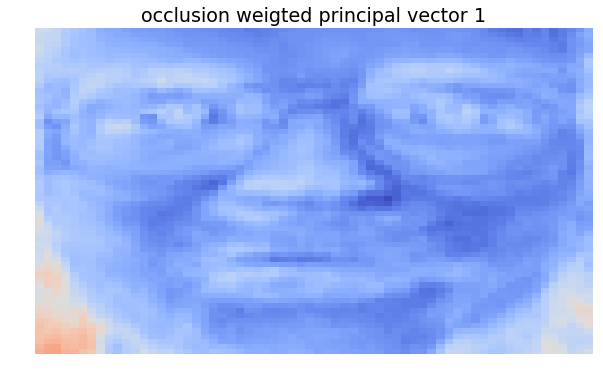

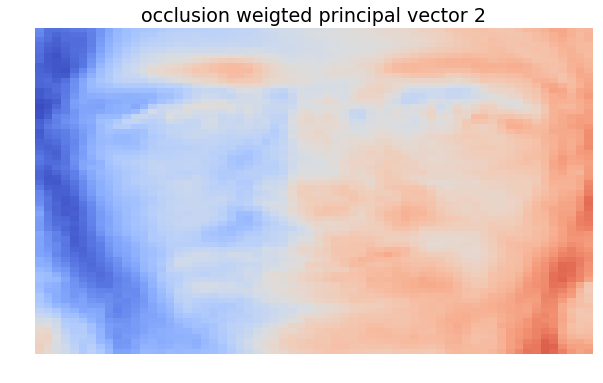

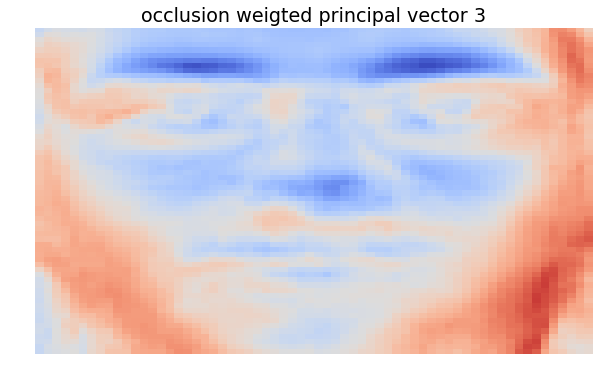

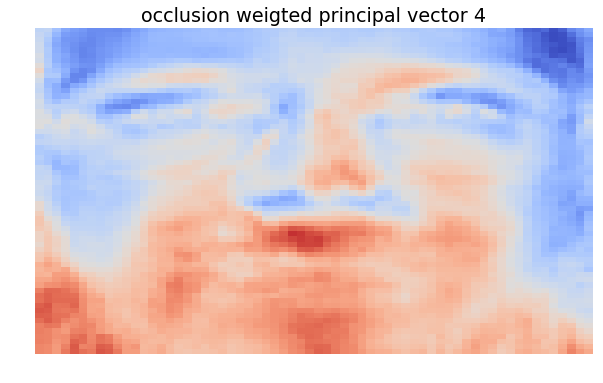

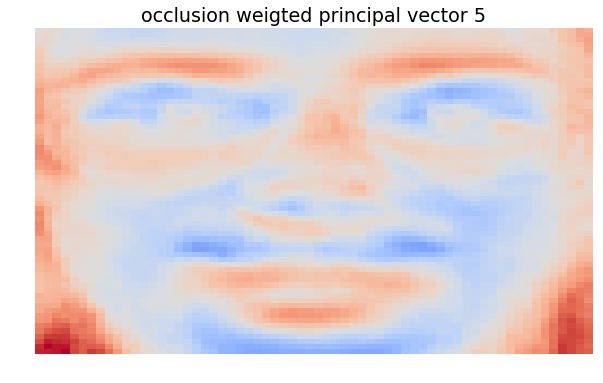

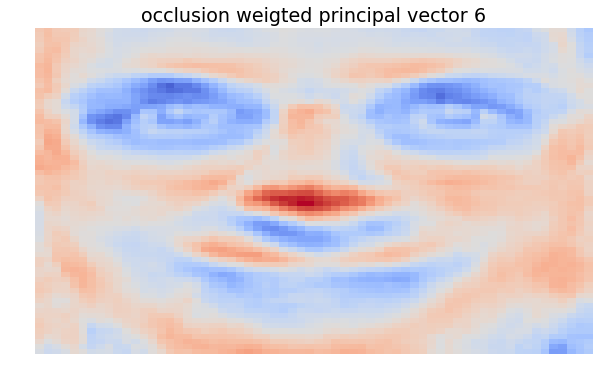

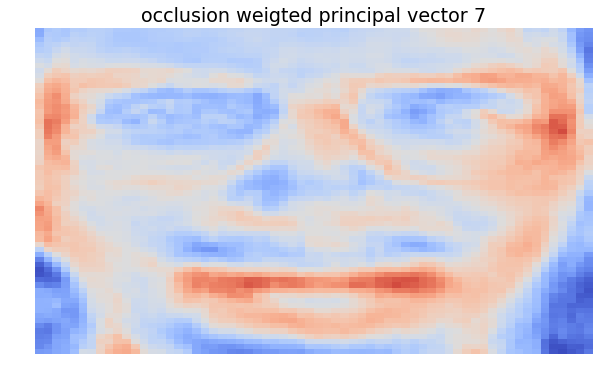

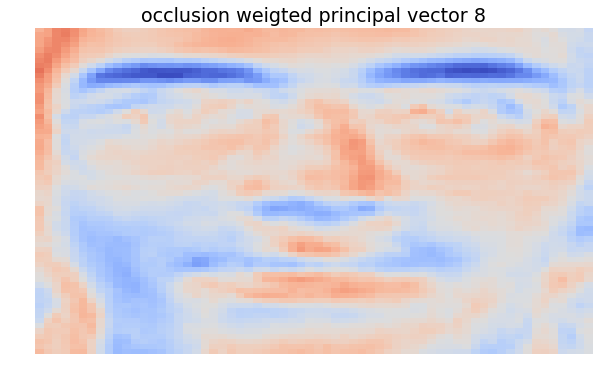

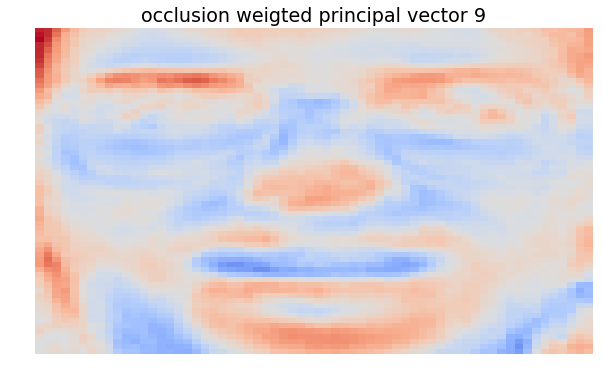

In [25]:
principal_vectors = solra.H_t.transpose()

for i in range(9):
    cvec = principal_vectors[i]
    max_mag = np.max(np.abs(cvec))
    view_as_image(cvec, cmap="coolwarm", vmin=-max_mag, vmax=max_mag)
    plt.title("occlusion weigted principal vector {}".format(i+1))
    plt.show()

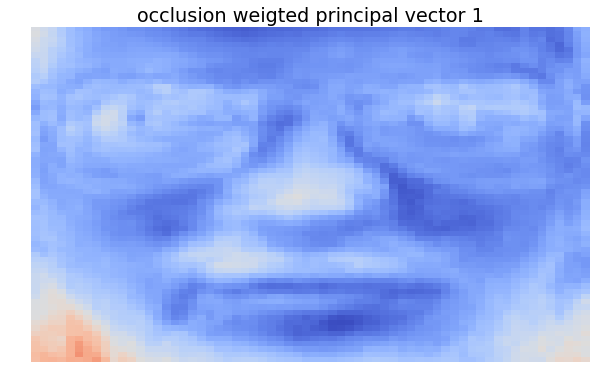

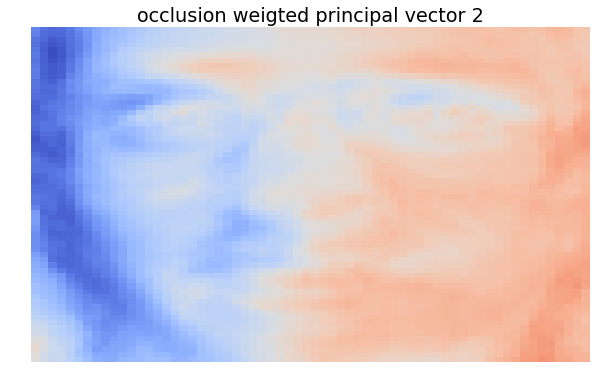

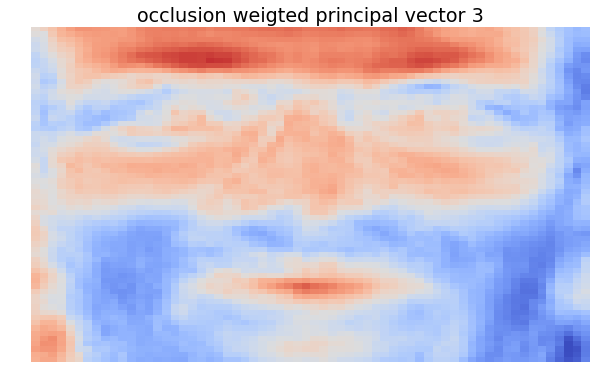

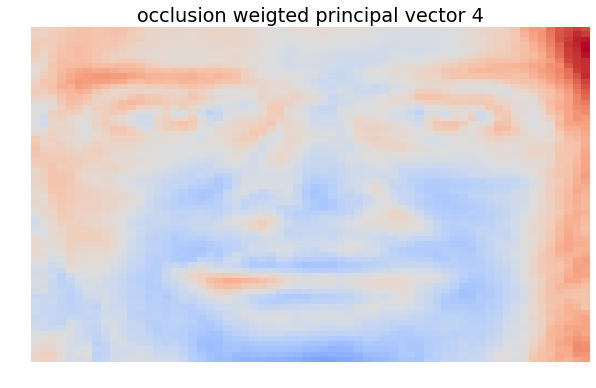

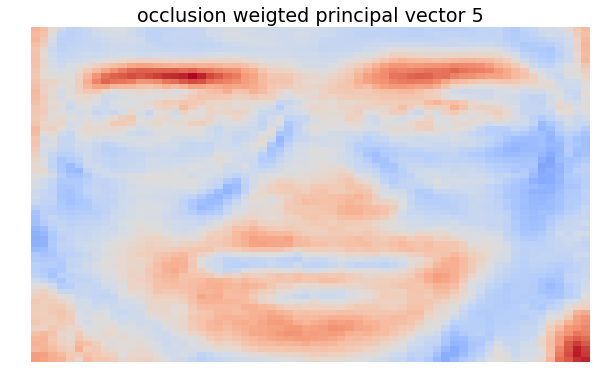

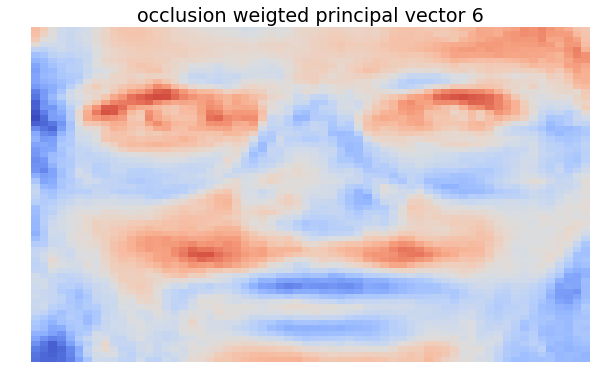

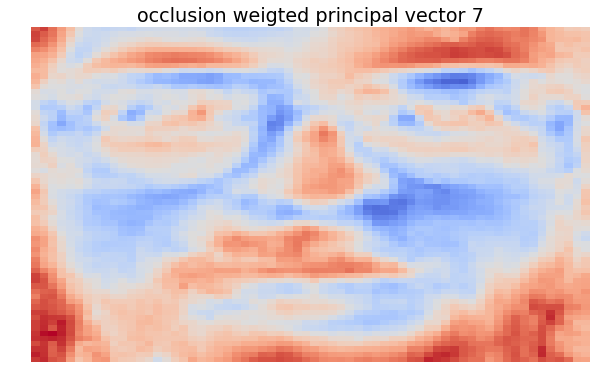

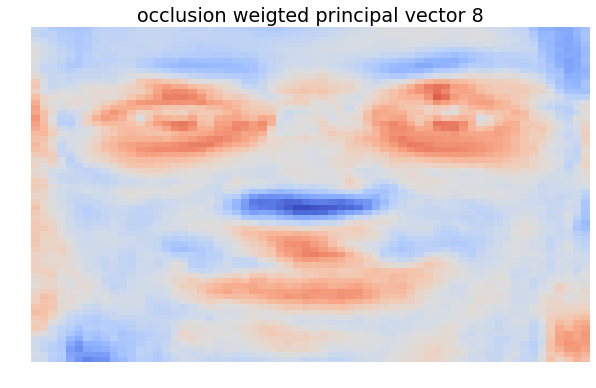

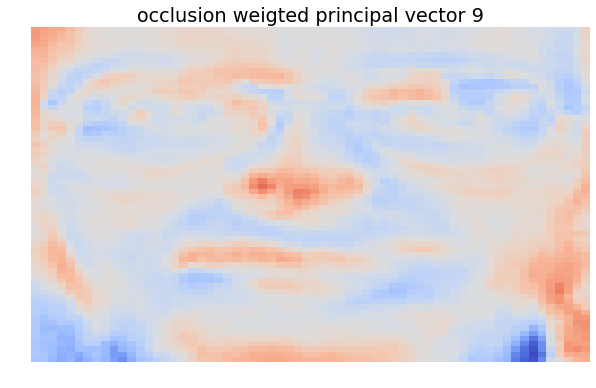

In [13]:
principal_vectors = wlra.H

for i in range(9):
    cvec = principal_vectors[i]
    max_mag = np.max(np.abs(cvec))
    view_as_image(cvec, cmap="coolwarm", vmin=-max_mag, vmax=max_mag)
    plt.title("occlusion weigted principal vector {}".format(i+1))
    plt.show()

Unfortunately this method is slower than the sklearn version and is not guaranteed to find the local optimum in a reasonable amount of time. However when missing data is an issue and simply dropping rows or columns with missing data is not an option accounting for the missing data in some way is essential. The principal vectors which we obtain from this procedure are clearly much more informative than those that we obtained directly from the SVD based sklearn implementation. 

If you recall the principal vectors that we obtained in part 1 you will note that these principal vectors are slightly different from those we originally found. These differences are partly due to the fact that the apparent covariance structure of our data has been significantly altered by masking out some of the pixels with the natural result that the apparent correlations between pixels are different. Some of the differences are also due to the fact that we have stopped somewhere shy of the true global optimum least squares solution. Also you might notice that some of the principal components as we originally calculated them. This is not a problem since the linear subspace spanned by the vectors is the same regardless of their sign.

## Imputation

Now that we have a decent learned representation of the face data we can use it to repair the parts of the image that we have masked out. The imputed data in this case is simply $W~H$ plus the mean face image.

In [27]:
imputation_model = np.dot(solra.W, solra.H_t.transpose()) + solra.mean

pca_imputed_faces = np.where(occlusion_mask, occluded_faces, imputation_model)
mean_imputed_faces = np.where(occlusion_mask, occluded_faces, wlra.mean)

Lets look at an example image and see how the imputation looks. 

Text(0.5,1,'PCA Imputed')

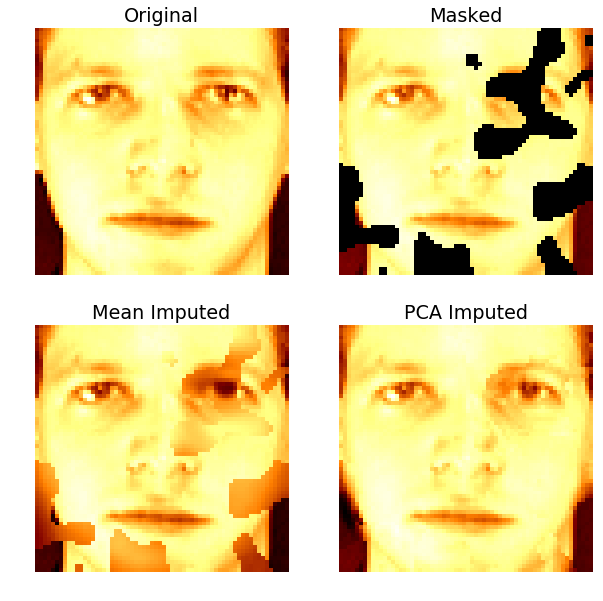

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

view_as_image(faces[0], ax=axes[0])
axes[0].set_title("Original")
view_as_image(occluded_faces[0], ax=axes[1])
axes[1].set_title("Masked")
view_as_image(mean_imputed_faces[0], ax=axes[2])
axes[2].set_title("Mean Imputed")
view_as_image(pca_imputed_faces[0], ax=axes[3])
axes[3].set_title("PCA Imputed")

While clearly imperfect the imputed image looks pretty decent. You might not even notice that the original image had been changed at all if you weren't paying close attention. The imputed parts of the image have lost some of their fine detail and look a little blurrier than the rest of the image.

The imputed data looks OK but lets try and quantify just how much better the PCA imputation does than simply using the mean.

In [30]:
np.std(pca_imputation_residuals)

0.6140862687869026

In [31]:
np.std(mean_imputation_residuals)

0.8402113235250431

Text(0,0.5,'Probability Density')

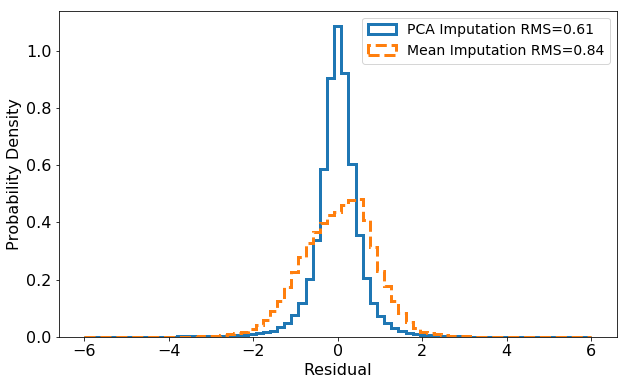

In [34]:
left_out_mask = np.logical_not(occlusion_mask)
pca_imputation_residuals = (faces-pca_imputed_faces)[left_out_mask]
mean_imputation_residuals = (faces-wlra.mean)[left_out_mask]

hist_kwargs = {
    "bins":71,
    "range":(-6,6),
    "histtype":"step",
    "normed":True,
    "lw":3,
}

plt.hist(
    pca_imputation_residuals,
    label="PCA Imputation RMS={:4.2f}".format(np.std(pca_imputation_residuals)), 
    **hist_kwargs
)
plt.hist(
    mean_imputation_residuals, 
    label="Mean Imputation RMS={:4.2f}".format(np.std(mean_imputation_residuals)),
    linestyle="--",
    **hist_kwargs
)

plt.legend(loc="best", fontsize=14)
plt.xlabel("Residual")
plt.ylabel("Probability Density")

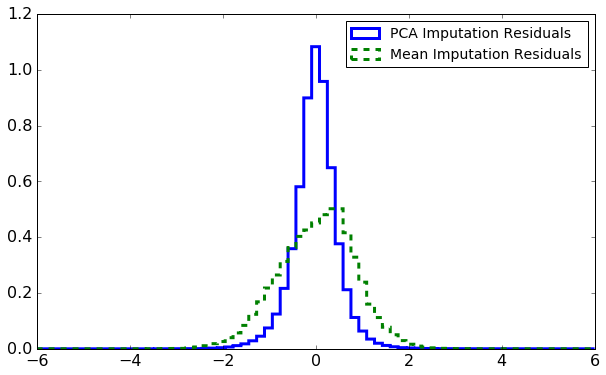

In [14]:
left_out_mask = np.logical_not(occlusion_mask)
pca_imputation_residuals = (faces-imputed_faces)[left_out_mask]
mean_imputation_residuals = (faces-wlra.mean)[left_out_mask]

hist_kwargs = {
    "bins":71,
    "range":(-6,6),
    "histtype":"step",
    "normed":True,
    "lw":3,
}

plt.hist(
    pca_imputation_residuals,
    label="PCA Imputation Residuals", 
    **hist_kwargs
)
plt.hist(
    mean_imputation_residuals, 
    label="Mean Imputation Residuals",
    linestyle="--",
    **hist_kwargs
)

plt.legend(loc="best", fontsize=14)

In [15]:
np.std(pca_imputation_residuals)/np.std(mean_imputation_residuals)

0.58565197966178517

The PCA imputation reduces the typical magnitude of residuals relative to mean imputation by almost a factor of two. We knew already that the pixels in these images are strongly correlated with each other and so it is no surprise that PCA should be able to do some amount of repair.  

Although the PCA imputed values look good this might represent a slight overestimate of the quality of reconstruction we can expect from pictures of new people. 
Although we were careful to not use any pixels to both train our PCA expansions and estimate imputation errors we have not done anything to handle the fact that there are multiple images of the same person in our dataset. If we really want to get a good picture for what our imputation errors would look like we should make training and validation folds with all pictures of an individual confined to the same fold.


Before you go out and use PCA to impute all your missing values in all your datasets consider a few pitfalls of this appraoch. Firstly PCA should only be used to impute values on datasets where there exist strong correlations between the input features. If the features are not strongly correlated then the imputed values will be poor predictions at best and you would effectively just be injecting cleverly disguised noise into your input data. Secondly using PCA to impute values comes at the steep cost of making it unclear which data originally had values and which did not which can be dangerous (for example over-inflating the confidence of predictions made on mostly missing data).

Data imputation is a good tool to have in your toolbox since it is sometimes the easiest thing to do but it is seldom the "right" thing to do. For example suppose you are using a machine learning model that has been trained on a cleaned dataset with no missing values but when you deploy this model you find that you must frequently make predictions on data with several values missing. The easy thing to do is to simply fill in the missing values somehow. But since your model has no way of knowing the difference between imputed values and valuable information your predictions will be less good than they could be. A much better idea is to go back to that same clean input dataset and then randomly censor pieces of information in a way that mimics what will be seen at prediction time. In this way your model can learn to deal with missing values in a productive way and your predictions will be better as a result.


## De-noising

Now we turn to the closely related problem of noise reduction. Here we don't have any missing values but instead our features are degraded by some amount of additive noise. We can use our learned PCA representation to project our input data ont the PCA expansion and then reconstruct it from there. The idea is that noise fluctuations will not correlate with the principal vectors and so will be attenuated wheras common input data variations will be captured and so the signal to noise of the resulting reconstruction will be higher than originally. Note however that this technique cannot add information it can only reject it and necessarily we will always reject some legitimate variation along with the noise. While it is true that it is possible to increase the signal to noise of our observations by rejecting more noise than signal this is harder than it sounds. Just as in the case of data imputation it is usually better to teach our models to deal with realistic amounts of noise than it is to try to reduce the noise in our inputs.


Lets apply pca as a noise reduction technique to one of our faces.

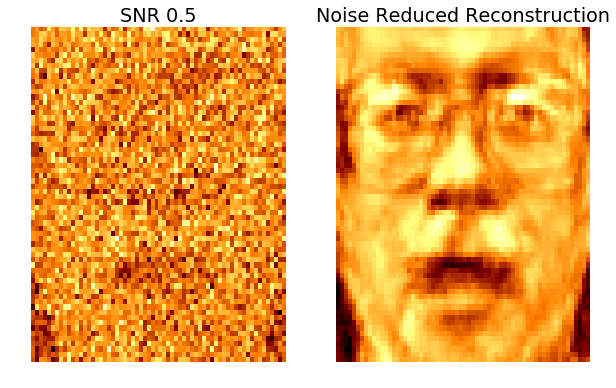

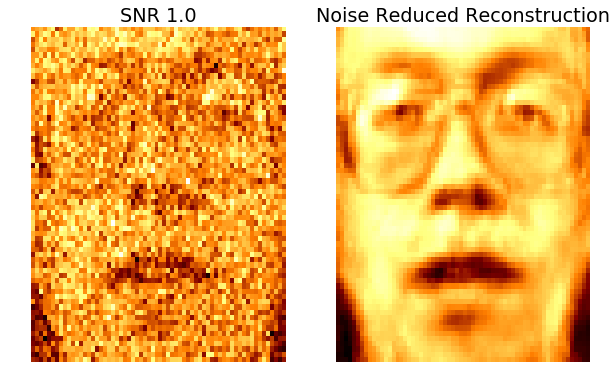

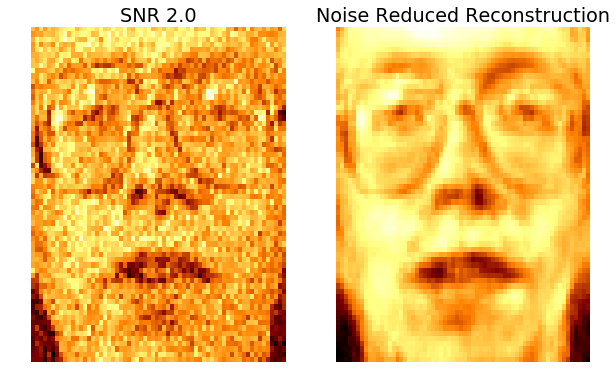

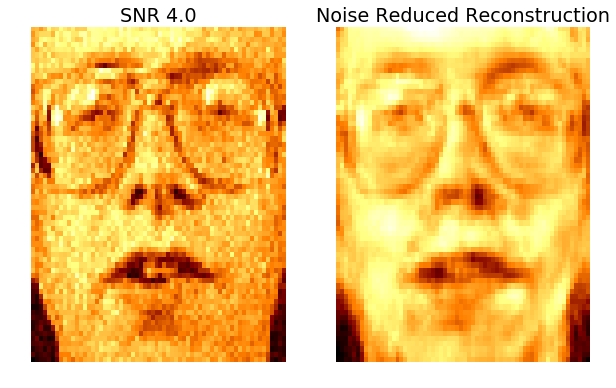

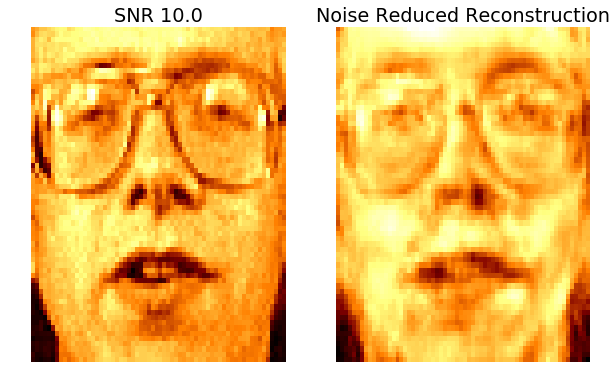

In [26]:
face_index = 10

for snr in [0.5, 1.0, 2.0, 4.0, 10.0]:
    fig, axes = plt.subplots(1, 2)
    noisy_image = snr*faces[face_index] + np.random.normal(size=faces[face_index].shape)
    
    pca_coeffs = np.dot(wlra.H, noisy_image-wlra.mean)
    reconstruction = np.dot(pca_coeffs, wlra.H) + wlra.mean
    
    axes[0].set_title("SNR {}".format(snr))
    axes[1].set_title("Noise Reduced Reconstruction")
    view_as_image(noisy_image, ax=axes[0])
    view_as_image(reconstruction, ax=axes[1])

For the noisier data in the example above it certainly looks like the reconstruction is doing an excellent job of picking out the signal. In fact again because we are taining on data which includes several images of this very same person the PCA reconstruction is probably doing a much better job at reconstruction than we could really expect in the wild on images of people it has never seen before. 

Note also that once the signal to noise of our input data is high enough the PCA reconstruction starts to do a worse job than simply using the input data. This is because the degrees of freedom in the input data are much higher than the number of principal components we are using to represent them. We can improve the PCA reconstruction quality by increasing the number of components we use for reconstruction but at the price of capturing more noise along with more signal and so consequently we get poorer de-noising performance. There are many things we can do to try and get around this for example we can attenuate the pca coefficients prior to reconstruction by various schemes which will often give us better performance. The idea is that the coefficients will in general have their magnitudes inflated slightly by the extra variance added to the data by the noise. By shrinking the coefficents towards 0 we can remove some of this extra noise based variance and get better reconstruction. However again there is no magic way to tell noise from signal and so attenuating our coefficients inevitably reduces the amount of signal in our output as well as reducing the noise so proceed with caution.

To give you a visual representation of my cautions that an apparent increase in data quality can be misleading consider what happens when we present this same "de-noising" technique with data that is 100% noise and 0% signal. Because our PCA expansion is trained to find faces any correlations of the input data with face like structures will be interpreted as "signal" and so our de-noising algorithm will quite happily hallucinate faces for us.

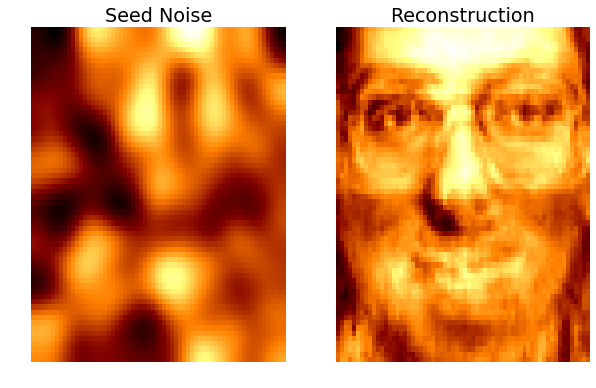

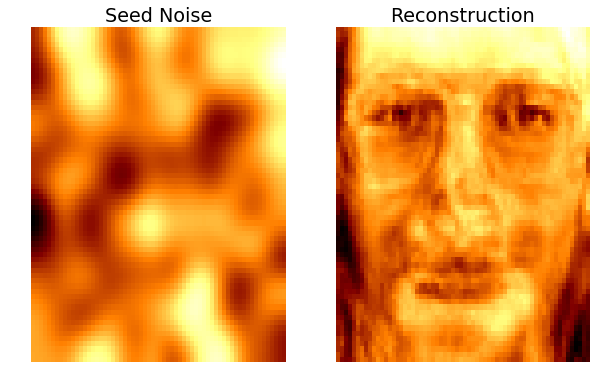

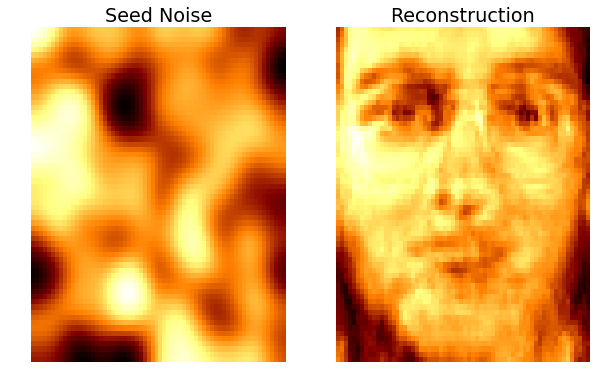

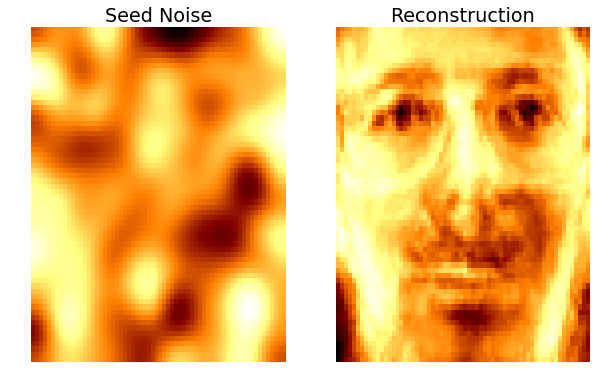

In [17]:
for i in range(4):
    fig, axes = plt.subplots(1, 2)
    noise = np.random.normal(size=faces[face_index].shape)
    #smooth the noise to reduce the number of degrees of freedom
    noise = scipy.ndimage.filters.gaussian_filter(noise.reshape(im_shape), 4).reshape((-1,))
    noise /= np.std(noise)
    
    pca_coeffs = np.dot(wlra.H, noise)
    reconstruction = np.dot(pca_coeffs, wlra.H) + wlra.mean
    
    axes[0].set_title("Seed Noise")
    axes[1].set_title("Reconstruction")
    view_as_image(noise, ax=axes[0])
    view_as_image(reconstruction, ax=axes[1])

Since our principal vectors encode structure that is face like whatever random fluctuations happen to connect to those vectors is what we pick up. I would not reccomend using this noise reduction technique prior to feeding data into a machine learning algorithm. However, if you are considering using PCA as a dimensionality reduction technique as part of a larger pipeline it is often a good idea to first look at what the pca based reconstruction of your data would look like. You might be able to capture 95% of the data variance with just 10 components but the information in that last 5% might be really important. Comparing each observation to its reconstruction will help to give you an idea of what structure the lower dimensional space is capturing and what it is leaving out.

If you are using the sklearn PCA class you can do reconstruction simply by chaining the transform and inverse_transform methods of the PCA object. This is exactly equivalent to the "de-noising" technique that we were using above.

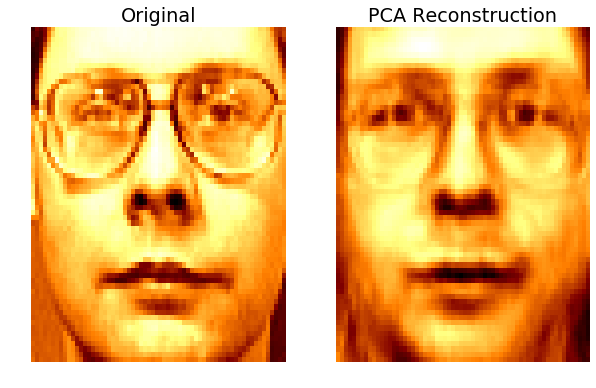

In [27]:
validation_subject = 3
subject_mask = subject_ids != validation_subject

train_faces = faces[subject_mask]
validation_faces = faces[np.logical_not(subject_mask)]

pca = sklearn.decomposition.PCA(n_components=50)
pca.fit(train_faces)

faces_pca_reconstruction = pca.inverse_transform(pca.transform(validation_faces))

fig, axes = plt.subplots(1, 2)
view_as_image(validation_faces[0], ax=axes[0])
view_as_image(faces_pca_reconstruction[0], ax=axes[1])

axes[0].set_title("Original")
axes[1].set_title("PCA Reconstruction")